**Общая информация**

**Срок сдачи:** 16 марта 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import  fetch_20newsgroups

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, KDTree, DistanceMetric
from sklearn.metrics import accuracy_score, pairwise_distances

from scipy.spatial.distance import euclidean

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm = 'brute', metric = 'euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.n_classes = np.unique(y).shape[0]
        return self
    
    def brute(self,X):
        dist = pairwise_distances(X, self.X_train, metric = self.metric)
        ind = np.argpartition(dist, self.n_neighbors, axis = 1)[:,:self.n_neighbors]
        return np.apply_along_axis(np.bincount,1,self.y_train[ind],
                                   minlength = self.n_classes).argmax(axis=1)
    def kd_tree(self,point):
        X = np.concatenate((point[np.newaxis,:],self.X_train),axis=0)
        tree = KDTree(X, metric = self.metric)
        ind = tree.query(X[:1], k=self.n_neighbors+1, return_distance = False)
        ind = ind.ravel()[1:]-1
        return np.bincount(self.y_train[ind]).argmax()
    
    def predict(self, X):
        if self.algorithm == 'brute':
            return self.brute(X)
        elif self.algorithm == 'kd_tree':
            return np.apply_along_axis(self.kd_tree, 1, X)   
        
    def score(self,X,y):
        return accuracy_score(y,self.predict(X))

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

MyKNeighborsClassifier(algorithm='brute', metric='euclidean', n_neighbors=2)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [8]:
%time clf.fit(X_train, y_train)

CPU times: user 701 µs, sys: 0 ns, total: 701 µs
Wall time: 527 µs


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [9]:
%time my_clf.fit(X_train, y_train)

CPU times: user 222 µs, sys: 0 ns, total: 222 µs
Wall time: 98 µs


MyKNeighborsClassifier(algorithm='brute', metric='euclidean', n_neighbors=2)

In [10]:
%time clf.predict(X_test)

CPU times: user 3.56 ms, sys: 0 ns, total: 3.56 ms
Wall time: 2.29 ms


array([2, 2, 0, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1, 2, 2])

In [11]:
%time my_clf.predict(X_test)

CPU times: user 1.51 ms, sys: 0 ns, total: 1.51 ms
Wall time: 994 µs


array([2, 2, 0, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1, 2, 2])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [12]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [14]:
%time clf.fit(X_train, y_train)

CPU times: user 993 µs, sys: 103 µs, total: 1.1 ms
Wall time: 659 µs


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [15]:
%time my_clf.fit(X_train, y_train)

CPU times: user 119 µs, sys: 12 µs, total: 131 µs
Wall time: 88.7 µs


MyKNeighborsClassifier(algorithm='kd_tree', metric='euclidean', n_neighbors=2)

In [16]:
%time clf.predict(X_test)

CPU times: user 3.2 ms, sys: 329 µs, total: 3.53 ms
Wall time: 2.41 ms


array([1, 1, 2, 2, 2, 0, 2, 0, 0, 1, 1, 0, 0, 1, 2])

In [17]:
%time my_clf.predict(X_test)

CPU times: user 3.79 ms, sys: 323 µs, total: 4.11 ms
Wall time: 3.26 ms


array([1, 1, 2, 2, 2, 0, 2, 0, 0, 1, 1, 0, 0, 1, 2])

In [18]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [19]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [20]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [21]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

best k is  1
all scores is  [0.20647002 0.18357767 0.18331286 0.18163378 0.18534599 0.18340184
 0.18428562 0.18755588 0.19144498 0.19153302]


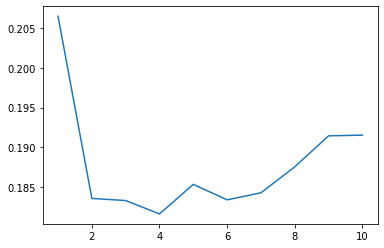

In [22]:
# answer = np.array([])         alternative example
# for k in range(10):
#     my_clf = MyKNeighborsClassifier(n_neighbors=k+1)
#     skf = StratifiedKFold(n_splits=3)
#     acc = np.mean([my_clf.fit(X[train_index], target[train_index])
#            .score(X[test_index], target[test_index]) for train_index, test_index in skf.split(X,target)])
#     answer = np.append(answer, acc)

# print('best k is ',answer.argmax()+1)
# print('all scores is ',answer)

answer = np.array([np.mean(cross_val_score(MyKNeighborsClassifier(n_neighbors=k+1),
                                           X, target, cv = 3)) for k in range(10)]) 
print('best k is ',answer.argmax()+1)
print('all scores is ',answer)
plt.plot(range(1,11), answer);

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

best k is  1
all scores is  [0.29238086 0.27258185 0.26904644 0.26577611 0.26232949 0.2578219
 0.25773339 0.25525869 0.2526071  0.24748091]


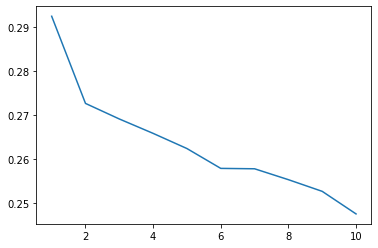

In [23]:
answer = np.array([np.mean(cross_val_score(MyKNeighborsClassifier(n_neighbors=k+1, metric = 'cosine'),
                                           X, target, cv = 3)) for k in range(10)]) 
print('best k is ',answer.argmax()+1)
print('all scores is ',answer)
plt.plot(range(1,11), answer);

In [24]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(data)

best k is  1
all scores is  [0.14875366 0.0917453  0.10526774 0.09978753 0.09589867 0.09103759
 0.08935844 0.08750254 0.08644177 0.08767879]


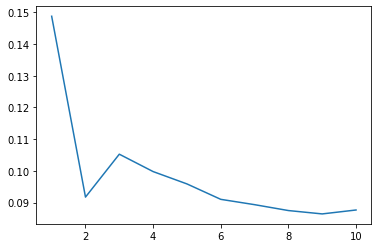

In [25]:
answer = np.array([np.mean(cross_val_score(MyKNeighborsClassifier(n_neighbors=k+1), 
                                           X_tfidf, target, cv = 3)) for k in range(10)])
print('best k is ',answer.argmax()+1)
print('all scores is ',answer)
plt.plot(range(1,11), answer);

best k is  1
all scores is  [0.59589958 0.55691954 0.56575853 0.57115002 0.571062   0.5684986
 0.56876397 0.56690794 0.56734976 0.56752688]


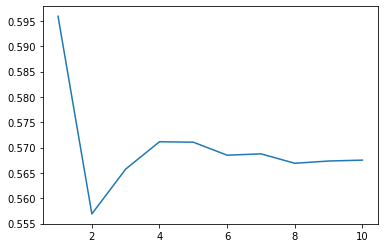

In [26]:
answer = np.array([np.mean(cross_val_score(MyKNeighborsClassifier(n_neighbors=k+1, metric = 'cosine'),
                                           X_tfidf, target, cv = 3)) for k in range(10)]) 

print('best k is ',answer.argmax()+1)
print('all scores is ',answer)
plt.plot(range(1,11), answer);

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [27]:
newsgroups_test = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

In [28]:
data_test = newsgroups_test['data']
target_test = newsgroups_test['target']

In [29]:
vectorizer_test = TfidfVectorizer()
X_test = vectorizer_test.fit_transform(data_test)

best k is  1
all scores is  [0.56531982 0.53093242 0.53611081 0.5436782  0.5541664  0.55456507
 0.55708773 0.55722047 0.56093835 0.56067238]


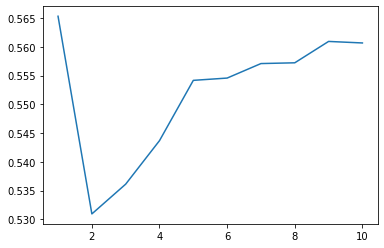

In [30]:
answer = np.array([np.mean(cross_val_score(MyKNeighborsClassifier(n_neighbors=k+1, metric = 'cosine'),
                                           X_test, target_test, cv = 3)) for k in range(10)]) 

print('best k is ',answer.argmax()+1)
print('all scores is ',answer)
plt.plot(range(1,11), answer);

best k is  1
all scores is  [0.56531982 0.53093242 0.53611081 0.5436782  0.5541664  0.55456507
 0.55708773 0.55722047 0.56093835 0.56067238 0.55748555 0.55350228
 0.55257288 0.55137813 0.54726206 0.5448721  0.54142035 0.53796813
 0.53610922 0.53305509]


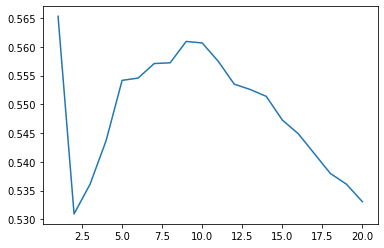

In [31]:
answer = np.array([np.mean(cross_val_score(MyKNeighborsClassifier(n_neighbors=k+1, metric = 'cosine'),
                                           X_test, target_test, cv = 3)) for k in range(20)]) 

print('best k is ',answer.argmax()+1)
print('all scores is ',answer)
plt.plot(range(1,21), answer);

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.